# Human Activity Recognition (HAR) Project

## Objective
Develop a deep learning model to recognize human activities using the UCI HAR Dataset

## Key Components
- Data Loading
- Preprocessing
- CNN-LSTM Model Architecture
- Model Training
- Performance Evaluation

## Technical Approach
- Convolutional Layers for Feature Extraction
- LSTM Layers for Sequence Processing
- Advanced Regularization Techniques

In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, 
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [7]:
class HumanActivityRecognitionPipeline:
    def __init__(self, dataset_path='UCI_HAR_Dataset/UCI HAR Dataset'):
        self.dataset_path = dataset_path
        self.TIME_STEPS = 51
        self.FEATURES_PER_STEP = 11
        
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
    
    def load_dataset(self):
        try:
            train_path = os.path.join(self.dataset_path, 'train')
            test_path = os.path.join(self.dataset_path, 'test')
            
            X_train = np.loadtxt(os.path.join(train_path, 'X_train.txt'))
            y_train = np.loadtxt(os.path.join(train_path, 'y_train.txt')).astype(int) - 1
            
            X_test = np.loadtxt(os.path.join(test_path, 'X_test.txt'))
            y_test = np.loadtxt(os.path.join(test_path, 'y_test.txt')).astype(int) - 1
            
            self._log_dataset_info(X_train, y_train, X_test, y_test)
            
            return X_train, y_train, X_test, y_test
        
        except Exception as e:
            print(f"Error loading dataset: {e}")
            raise
    
    def _log_dataset_info(self, X_train, y_train, X_test, y_test):
        print("Dataset Information:")
        print(f"Training Features Shape: {X_train.shape}")
        print(f"Training Labels Shape: {y_train.shape}")
        print(f"Testing Features Shape: {X_test.shape}")
        print(f"Testing Labels Shape: {y_test.shape}")
    
    def preprocess_data(self, X_train, y_train, X_test, y_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        X_train_reshaped = X_train_scaled.reshape(
            -1, self.TIME_STEPS, self.FEATURES_PER_STEP
        )
        X_test_reshaped = X_test_scaled.reshape(
            -1, self.TIME_STEPS, self.FEATURES_PER_STEP
        )
        
        y_train_cat = to_categorical(y_train)
        y_test_cat = to_categorical(y_test)
        
        self._log_preprocessed_info(
            X_train_reshaped, y_train_cat, 
            X_test_reshaped, y_test_cat
        )
        
        return X_train_reshaped, y_train_cat, X_test_reshaped, y_test_cat
    
    def _log_preprocessed_info(self, X_train, y_train, X_test, y_test):
        print("Preprocessed Data Information:")
        print(f"Training Features Shape: {X_train.shape}")
        print(f"Training Labels Shape: {y_train.shape}")
        print(f"Testing Features Shape: {X_test.shape}")
        print(f"Testing Labels Shape: {y_test.shape}")
    
    def build_model(self, input_shape, num_classes):
        model = Sequential([
            Conv1D(
                filters=128, 
                kernel_size=3, 
                activation='relu', 
                input_shape=input_shape,
                padding='same'
            ),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            
            Conv1D(
                filters=256, 
                kernel_size=3, 
                activation='relu',
                padding='same'
            ),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            
            LSTM(128, return_sequences=True),
            LSTM(64, return_sequences=False),
            
            Dropout(0.5),
            
            Dense(
                100, 
                activation='relu',
                kernel_regularizer=l2(0.001)
            ),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        
        model.summary()
        
        return model
    
    def train_model(self, model, X_train, y_train, X_test, y_test):
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy', 
                patience=15, 
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.5, 
                patience=7,
                min_lr=1e-6
            )
        ]
        
        history = model.fit(
            X_train, y_train, 
            epochs=100, 
            batch_size=32, 
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        return history
    
    def evaluate_model(self, model, X_test, y_test):
        loss, accuracy = model.evaluate(X_test, y_test)
        print("Model Performance:")
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)
        
        print("Detailed Classification Report:")
        print(classification_report(y_true_classes, y_pred_classes))
        
        self._plot_confusion_matrix(y_true_classes, y_pred_classes)
        
        return loss, accuracy
    
    def _plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    
    def run_pipeline(self):
        try:
            X_train_raw, y_train_raw, X_test_raw, y_test_raw = self.load_dataset()
            
            X_train, y_train, X_test, y_test = self.preprocess_data(
                X_train_raw, y_train_raw, X_test_raw, y_test_raw
            )
            
            model = self.build_model(
                input_shape=(self.TIME_STEPS, self.FEATURES_PER_STEP), 
                num_classes=y_train.shape[1]
            )
            
            history = self.train_model(model, X_train, y_train, X_test, y_test)
            
            loss, accuracy = self.evaluate_model(model, X_test, y_test)
            
            return model, history
        
        except Exception as e:
            print(f"Pipeline execution failed: {e}")
            raise

Dataset Information:
Training Features Shape: (7352, 561)
Training Labels Shape: (7352,)
Testing Features Shape: (2947, 561)
Testing Labels Shape: (2947,)
Preprocessed Data Information:
Training Features Shape: (7352, 51, 11)
Training Labels Shape: (7352, 6)
Testing Features Shape: (2947, 51, 11)
Testing Labels Shape: (2947, 6)


C:\Users\Computec\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 51, 128)             │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 51, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 25, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 12, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 12, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 358,082 (1.37 MB)

 Trainable params: 357,314 (1.36 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5480 - loss: 1.1444 - val_accuracy: 0.7710 - val_loss: 0.5835 - learning_rate: 5.0000e-04
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9224 - loss: 0.3155 - val_accuracy: 0.8935 - val_loss: 0.4202 - learning_rate: 5.0000e-04
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9586 - loss: 0.2087 - val_accuracy: 0.9250 - val_loss: 0.3335 - learning_rate: 5.0000e-04
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9783 - loss: 0.1396 - val_accuracy: 0.8812 - val_loss: 0.4996 - learning_rate: 5.0000e-04
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9783 - loss: 0.1377 - val_accuracy: 0.9030 - val_loss: 0.4809 - learning_rate: 5.0000e-04
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9878 - loss: 0.1031 - val_accuracy: 0.8385 - val_loss: 0.9529 - learning_rate: 5.0000e-04
Epoch 7/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/st

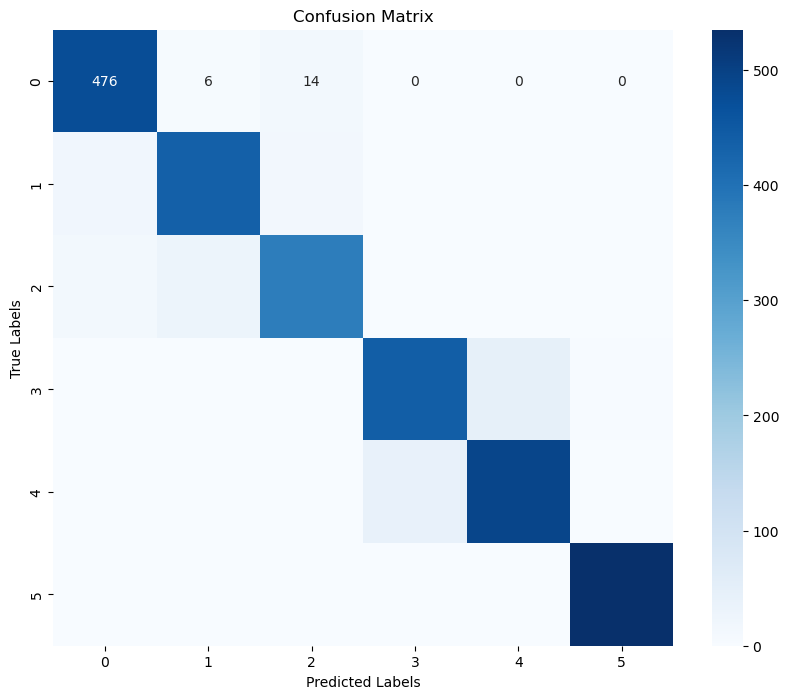

In [8]:
# Initialize and run the pipeline
har_pipeline = HumanActivityRecognitionPipeline()
model, history = har_pipeline.run_pipeline()

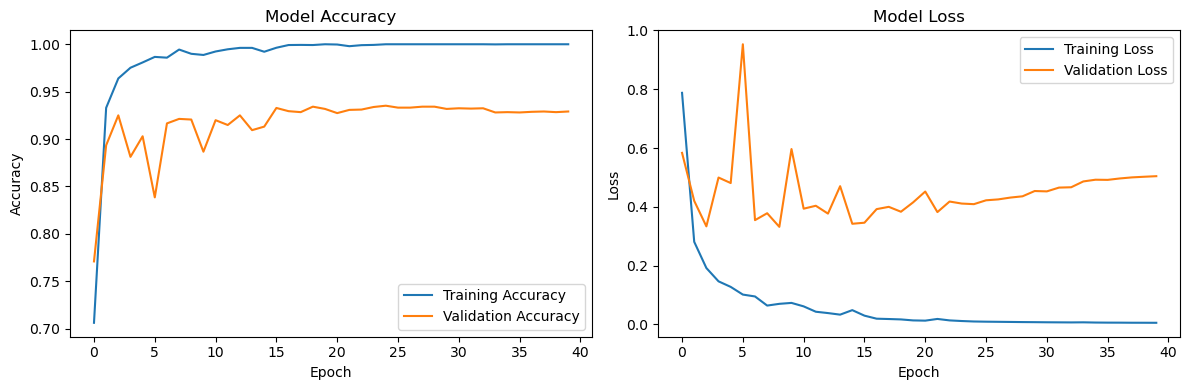

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Save the trained model
model_save_path = 'har_cnn_lstm_model.h5'
model.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

Model saved successfully at: har_cnn_lstm_model.h5
